# statistics and plotting of capture seq runs

Author: Etienne Kornobis 2021-2022

Scripts from Sequana https://sequana.readthedocs.io

Data from https://github.com/sequana/mapper pipeline 

In [43]:
DATA_DIR = "/pasteur/zeus/projets/p02/BiomicsData/"
DATA_LINK_DIR = "data/"
RESULTS_DIR = "/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper"
INFO_FILE = "info.json"
TABLE_OUT = "summary.xlsx"


In [14]:
import json
from pathlib import Path
import pandas as pd
import parse
import sys
import pysam
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sequana.fasta import FastA
from sequana.bamtools import SAMBAMbase
import shutil
from collections import Counter

%matplotlib inline
matplotlib.style.use('seaborn-colorblind')
matplotlib.pyplot.rcParams['figure.figsize'] = 14, 6

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.1f}'.format

writer = pd.ExcelWriter(TABLE_OUT)

# Statistics and vizualisations

## Design

Information on the capture kits, sequencing technologies, runs and sample groups.

In [11]:
with open(INFO_FILE, "r") as f:
    info = json.load(f)

groups_df = pd.DataFrame(info["groups"]).melt().rename(columns={'variable': 'group', 'value': 'sample_id'})
groups_df = groups_df.astype({'sample_id':str})
cts_df = pd.DataFrame(info["cts"], index=["ct"]).transpose().reset_index().rename(columns={'index': 'sample_id'})
# Joining groups and cts
groups_df = cts_df.merge(groups_df, on="sample_id")

groups_df.to_excel(writer, sheet_name="groups", index=False, na_rep="NA")
writer.save()
groups_df

,sample_id,ct,group
0,4885,26.1,A
1,4716,25.8,A
2,4660,26.6,A
3,4520,25.5,A
4,4707,28.6,B
5,4697,28.7,B
6,4676,28.9,B
7,4653,29.3,B
8,4861,33.0,C
9,4787,32.6,C


In [33]:
design_df = pd.DataFrame(info["runs"]).transpose().reset_index().rename(columns={'index':'experiment'})


Link all datasets to DATA_DIR folder, organizing by experiments:

In [31]:
for index, row in design_df.iterrows():
    link_dir = Path(DATA_LINK_DIR) / row.experiment
    data_dir = Path(DATA_DIR) / row.path / "fastq" / "B3910"
    
    try:link_dir.mkdir()
    except FileExistsError: pass

    print(f"{len([x for x in data_dir.glob('*.fastq.gz')])} links created in {link_dir}")
    for fq in data_dir.glob("*.fastq.gz"):
        link_path = link_dir / fq.name
        try:link_path.symlink_to(fq)
        except FileExistsError:pass

38 links created in data/arbo_double_is
38 links created in data/arbo_double_ms
20 links created in data/arbo_double_10plex_ms
38 links created in data/arbo_single_is
38 links created in data/arbo_single_ms
38 links created in data/illumina_resv_is
38 links created in data/illumina_resv_ms
38 links created in data/illumina_resv_ns
42 links created in data/meta_is
42 links created in data/meta_ns
40 links created in data/twist_cov_is
40 links created in data/twist_cov_ms
40 links created in data/twist_cov_ns
38 links created in data/twist_panviral_is
38 links created in data/twist_panviral_ns
20 links created in data/twist_cov_10plex_ms
40 links created in data/twist_cov_LB_ms


In [32]:
# Verifying data present in data directory match the design
data_dir = Path(DATA_LINK_DIR)

data_dict = {}
for dataset in data_dir.glob("*"):
    
    if dataset.is_dir():
        libs = [lib for lib in dataset.iterdir()]
    
        # Extract the link path and the name of the run from folder name
        run_ids = set([lib.resolve().parent.parent.parent.stem for lib in libs if lib])
    
        data_dict[dataset.stem] = {"run_ids": ",".join(run_ids), "n_libs": len(libs) / 2}

data_df = pd.DataFrame(data_dict).transpose().reset_index().rename(columns={'index':'experiment'})

design_df = design_df.merge(data_df, on='experiment', how='outer')
design_df.to_excel(writer, sheet_name="design", index=False, na_rep="NA")
writer.save()

In [6]:
design_df

,experiment,path,description,run_ids,n_libs
0,arbo_double_is,2020/ISeq100/20200423_FS10001183_4_BPL20309-2627,Arbor Sars-cov simple capture,20200423_FS10001183_4_BPL20309-2627,19.0
1,arbo_double_ms,2020/MiSeq/200427_M01626_0470_000000000-CVJBF,Arbor Sars-cov double capture : Miseq,200427_M01626_0470_000000000-CVJBF,19.0
2,arbo_double_10plex_ms,2020/MiSeq/200511_M05218_0203_000000000-J533H,Arbor Double Capture Sars-cov 10plex,200511_M05218_0203_000000000-J533H,10.0
3,arbo_single_is,2020/ISeq100/20200428_FS10001183_5_BPL20316-3113,Arbor Sars-cov SIMPLE CAPTURE : Iseq100,20200428_FS10001183_5_BPL20316-3113,19.0
4,arbo_single_ms,2020/MiSeq/200504_M05218_0201_000000000-J534C,Arbor Sars-cov SIMPLE CAPTURE : Miseq,200504_M05218_0201_000000000-J534C,19.0
5,illumina_resv_is,2020/ISeq100/20200421_FS10001183_3_BPL20309-1531,Illumina capture ResV : ISeq100,20200421_FS10001183_3_BPL20309-1531,19.0
6,illumina_resv_ms,2020/MiSeq/200504_M01626_0471_000000000-J4VCN,Illumina capture ResV : Miseq,200504_M01626_0471_000000000-J4VCN,19.0
7,illumina_resv_ns,2020/NextSeq500/200504_NB501291_0237_AHM3NCBGXF,Illumina capture ResV : Nextseq,200504_NB501291_0237_AHM3NCBGXF,19.0
8,meta_is,2020/ISeq100/20200416_FS10001183_1_BPL20316-3215,Pré-capture ( métagénomique shotgun) : Iseq100,20200416_FS10001183_1_BPL20316-3215,21.0
9,meta_ns,2020/NextSeq500/200417_NS500199_0381_AH3YVWBGXB,Pré-capture ( métagénomique shotgun) : NextSeq500,200417_NS500199_0381_AH3YVWBGXB,21.0


In [34]:
data_df

,experiment,run_ids,n_libs
0,illumina_resv_ms,200504_M01626_0471_000000000-J4VCN,19.0
1,arbo_double_10plex_ms,200511_M05218_0203_000000000-J533H,10.0
2,twist_cov_is,20200420_FS10001183_2_BPA73110-1809,20.0
3,arbo_single_ms,200504_M05218_0201_000000000-J534C,19.0
4,meta_ns,200417_NS500199_0381_AH3YVWBGXB,21.0
5,twist_panviral_is,20200420_FFSMP030_20_BPL20308-2821,19.0
6,twist_cov_LB_ms,200514_M05218_0205_000000000-J56F6,20.0
7,meta_is,20200416_FS10001183_1_BPL20316-3215,21.0
8,twist_cov_10plex_ms,200506_M05218_0202_000000000-J57BC,10.0
9,illumina_resv_is,20200421_FS10001183_3_BPL20309-1531,19.0


## Mapping statistics

In [39]:
bamtools_parse = """
**********************************************
Stats for BAM file(s): 
**********************************************

Total reads:       {total_reads:d}
Mapped reads:      {mapped_reads:d}	({mapped_reads_perc:g}%)
Forward strand:    {forward_strand:d}	({forward_strand_perc:g}%)
Reverse strand:    {reverse_strand:d}	({reverse_strand_perc:g}%)
Failed QC:         {failed_qc:d}	({failed_qc_perc:g}%)
Duplicates:        {duplicates:d}	({duplicates_perc:g}%)
Paired-end reads:  {paired_reads:d}	({paired_reads_perc:g}%)
'Proper-pairs':    {proper_pairs:d}	({proper_pairs_perc:g}%)
Both pairs mapped: {both_mapped:d}	({both_mapped_perc:g}%)
Read 1:            {read1:d}
Read 2:            {read2:d}
Singletons:        {singletons:d}	({singletons_perc:g}%)

"""

In [40]:
def get_alignment_stats(analysis_folder):
    
    map_log_pattern = "**/bamtools_stats/*.txt"
    
    bam_stats_dict = {}
    
    for ali_log in Path(analysis_folder).glob(map_log_pattern):
        with open(ali_log, "r") as f:
            parsed_res = parse.parse(bamtools_parse, f.read())
            bam_stats_dict[ali_log.parent.parent.stem] = parsed_res.named
    
    df = pd.DataFrame(bam_stats_dict).transpose()
    df.loc[:,"mapped_reads_per_million"] = df.loc[:,"mapped_reads_perc"] * 10_000
    return df

def get_coverage_stats(analysis_folder, coverage=True):
    
    sequana_coverage_json_pattern = "**/sequana_coverage/*/*.json"

    coverage_dict = {}
    for j in Path(analysis_folder).glob(sequana_coverage_json_pattern):
        with open(j, "r") as f:
            json_text = json.load(f)
            data = json_text['data']
            data.pop("hist_coverage")
            lib_name = j.parent.parent.parent.stem
            coverage_dict[lib_name] = data
        
    df = pd.DataFrame(coverage_dict)
    if coverage:
        df = df.loc[["BOC", "DOC", "CV" ]].astype("float")
    return df.transpose()

def plot_by_groups(df,x, y, hue, title, log=False, hue_order=None, palette=None, swarmplot=True):
    with sns.color_palette(palette): 
        test_plot = sns.barplot(x=x, y=y, hue=hue, log=log,
                                data=df.reset_index().sort_values(y, ascending=False),
                                hue_order=hue_order, order=sorted(df[x].unique()),
                                errwidth=1)
        if swarmplot:
            test_plot = sns.swarmplot(x=x, y=y, data=df.reset_index().sort_values(y, ascending=False),
                                      hue=hue, hue_order=hue_order, order=sorted(df[x].unique()), dodge=True, color="black")
    _ = test_plot.set_title(title)
    
    # Remove the unecessary legend for the swarmplot
    handles, labels = test_plot.get_legend_handles_labels()
    idx = len(df.loc[:,hue].unique())
    test_plot.legend(handles[idx:], labels[idx:], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

def summarize_mapping(results_dir, coverage=True):

    if coverage:
        selected_columns = ["total_reads", "mapped_reads", "mapped_reads_perc", "mapped_reads_per_million", "proper_pairs", "BOC", "DOC", "CV"]
    else:
        selected_columns = ["total_reads", "mapped_reads", "mapped_reads_perc", "mapped_reads_per_million", "proper_pairs"]
        
    analysis_folders = sorted([x for x in Path(results_dir).glob("*") if x.is_dir()])
    all_dfs = []
    
    for count, analysis_folder in enumerate(analysis_folders):
        df = pd.concat([get_alignment_stats(analysis_folder), get_coverage_stats(analysis_folder, coverage)], axis=1)
        experiment = analysis_folder.stem
        df = df.loc[:,selected_columns].sort_index()
    
        # Add experiment
        df.loc[:,"experiment"] = experiment
        df.index.names = ["sample_id"]
        # Get id from seq run names
        df = df.reset_index()
        # Some sample id contains "-M10" for multiplexed 10, so replacing it by "_" to keep the same sample id
        df.loc[:,"sample_id"] = [x.replace("-", "_").split("_")[0] for x in df.loc[:,"sample_id"]]
        all_dfs.append(df)

    print(f"A total of {count + 1} experiments have been summarized.")
    summary_df = pd.concat(all_dfs)

    # Correct sample_id names for Water control
    summary_df.sample_id = summary_df.sample_id.replace("Controle-Negatif-water", "Cneg")

    # Add groups
    summary_df = pd.merge(summary_df, groups_df, on='sample_id')
    
    # # Add normalization by million read sequenced for the DOC
    if coverage:
        summary_df.loc[:,"DOC_norm"] = summary_df.DOC / summary_df.total_reads * 1000000
        summary_df.loc[:,"BOC_norm"] = summary_df.BOC / summary_df.total_reads * 1000000
    
    return summary_df

In [45]:
summary_df = summarize_mapping(RESULTS_DIR)
summary_df.to_excel(writer, sheet_name="mapping_complete", index=False, na_rep="NA")

summary_df_pub = summary_df.loc[:,["sample_id", "ct", "group", "experiment", "mapped_reads_perc", "BOC", "DOC"]]
summary_df.to_excel(writer, sheet_name="mapping_pub", index=False, na_rep="NA")
writer.save()
summary_df

A total of 19 experiments have been summarized.


,sample_id,total_reads,mapped_reads,mapped_reads_perc,mapped_reads_per_million,proper_pairs,BOC,DOC,CV,experiment,ct,group,DOC_norm,BOC_norm
0,4489,320934.0,85559.0,26.7,266594.0,84552.0,60.7,396.0,1.6,arbo_double_10plex_ms,35.1,D,1233.8,189.2
1,4489,895644.0,258640.0,28.9,288775.0,95496.0,94.6,1198.3,0.9,arbo_double_is,35.1,D,1337.9,105.6
2,4489,3726702.0,1128498.0,30.3,302814.0,1118722.0,94.6,5287.2,0.9,arbo_double_ms,35.1,D,1418.7,25.4
3,4489,679762.0,1728.0,0.3,2542.1,816.0,87.9,7.6,0.9,arbo_single_is,35.1,D,11.2,129.3
4,4489,2987580.0,7350.0,0.2,2460.2,7282.0,93.7,32.5,0.8,arbo_single_ms,35.1,D,10.9,31.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,4510,1708210.0,633819.0,37.1,371043.0,587744.0,95.7,3042.7,0.7,twist_cov_LB_ms,34.6,D,1781.2,56.0
346,4510,44895698.0,35145658.0,78.3,782829.0,23938974.0,95.4,142366.3,0.7,twist_cov_hg38_bwt2_depletion_ns,34.6,D,3171.0,2.1
347,4510,865012.0,371844.0,43.0,429871.0,275270.0,94.7,1459.7,0.7,twist_cov_is,34.6,D,1687.4,109.5
348,4510,2387346.0,1118723.0,46.9,468605.0,1112426.0,94.9,4491.9,0.7,twist_cov_ms,34.6,D,1881.6,39.7


### On target

In [46]:
def get_ref_bam_stats(bamfile, classif_csv):
    
    classif_df = pd.read_csv(classif_csv, index_col="id")\
    .drop_duplicates()\
    .reset_index()
    
    with pysam.AlignmentFile(bamfile, "rb") as bam:
        unmapped = bam.unmapped
        mapped_to_human = sum([bam.count(chrom, read_callback="all") for chrom in classif_df.query("classification == 'human'").id])
        mapped_to_sars_wuhan = sum([bam.count(chrom, read_callback="all") for chrom in classif_df.query("classification == 'wuhan_cov'").id])
        mapped = bam.mapped
        total = unmapped + mapped
    
    return {
        "human": mapped_to_human,
        "SARS-CoV-2": mapped_to_sars_wuhan,
        "other": unmapped,
        "total": total
    }

def get_on_target_mapping_stats(analysis_dirs, classif_csv, dir_pattern="*"):
    all_dfs = []

    for count, analysis_dir in enumerate(analysis_dirs):
        
        bams_pattern = "**/bowtie2_mapping_ref/*sorted.bam"
        experiment = analysis_dir.stem
        
        for bam in analysis_dir.glob(bams_pattern):
            print(bam)
            
            sample_id = bam.stem.split("_")[0]
            map_stats = get_ref_bam_stats(bam, classif_csv)
            map_stats["experiment"] = experiment
            map_stats["sample_id"] = sample_id
            all_dfs.append(map_stats)
            
    return pd.DataFrame(all_dfs)

def aggregate_target_dfs(dfs_list):
    df = pd.DataFrame(dfs_list)
    df = df.set_index(["sample_id", "experiment"])
    df = df.divide(df.total, axis=0).reset_index()
    df = df.merge(groups_df, on="sample_id")
    df = df.sort_values("ct")
    df = df.astype({"ct": str})
    
    return df

def plot_barplot(df, title="", ax=None, legend=False, legendy=1.11):
    #fig, ax = plt.subplots()

    cmap = sns.color_palette("colorblind", as_cmap=True)
    ax.bar(df.ct, df.loc[:,"SARS-CoV-2"], label='SARS-CoV-2', color=cmap[2])
    ax.bar(df.ct, df.human, label='human', bottom=df.loc[:, "SARS-CoV-2"], color=cmap[0])
    ax.bar(df.ct, df.other, bottom=df.human + df.loc[:,"SARS-CoV-2"],
       label='unmapped', color=cmap[1])
    if legend:
        ax.legend(bbox_to_anchor=(legendy, 0.5), loc=10, borderaxespad=0.)
    ax.set_xticklabels(df.ct, rotation=45)
    ax.set_title(title)

#### Sequencing technologies
- Twist IS, MS, NS

In [47]:
ontarget_tech_dirs = sorted([x for x in Path("/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2")\
                             .glob("twist_cov_?s") if x.is_dir()])
ontarget_tech_dirs

[PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is'),
 PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms'),
 PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns')]

In [49]:
dfs_ontarget_tech = get_on_target_mapping_stats(ontarget_tech_dirs, 
                                                "/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/resources/pan_with_humans.csv")

/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4489_S16_L001/bowtie2_mapping_ref/4489_S16_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4489_S16_L001/bowtie2_mapping_ref/4489_S16_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4544_S20_L001/bowtie2_mapping_ref/4544_S20_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4544_S20_L001/bowtie2_mapping_ref/4544_S20_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4797_S18_L001/bowtie2_mapping_ref/4797_S18_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4797_S18_L001/bowtie2_mapping_ref/4797_S18_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4656_S19_L001/bowtie2_mapping_ref/4656_S19_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4656_S19_L001/bowtie2_mapping_ref/4656_S19_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4510_S15_L001/bowtie2_mapping_ref/4510_S15_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4510_S15_L001/bowtie2_mapping_ref/4510_S15_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4798_S17_L001/bowtie2_mapping_ref/4798_S17_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4798_S17_L001/bowtie2_mapping_ref/4798_S17_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_is/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4489_S16_L001/bowtie2_mapping_ref/4489_S16_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4489_S16_L001/bowtie2_mapping_ref/4489_S16_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4544_S20_L001/bowtie2_mapping_ref/4544_S20_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4544_S20_L001/bowtie2_mapping_ref/4544_S20_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4797_S18_L001/bowtie2_mapping_ref/4797_S18_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4797_S18_L001/bowtie2_mapping_ref/4797_S18_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4656_S19_L001/bowtie2_mapping_ref/4656_S19_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4656_S19_L001/bowtie2_mapping_ref/4656_S19_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4510_S15_L001/bowtie2_mapping_ref/4510_S15_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4510_S15_L001/bowtie2_mapping_ref/4510_S15_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4798_S17_L001/bowtie2_mapping_ref/4798_S17_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4798_S17_L001/bowtie2_mapping_ref/4798_S17_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4489_S15/bowtie2_mapping_ref/4489_S15.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4489_S15/bowtie2_mapping_ref/4489_S15.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4656_S18/bowtie2_mapping_ref/4656_S18.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4656_S18/bowtie2_mapping_ref/4656_S18.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4797_S17/bowtie2_mapping_ref/4797_S17.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4797_S17/bowtie2_mapping_ref/4797_S17.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4520_S4/bowtie2_mapping_ref/4520_S4.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4520_S4/bowtie2_mapping_ref/4520_S4.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4787_S10/bowtie2_mapping_ref/4787_S10.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4787_S10/bowtie2_mapping_ref/4787_S10.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4777_S13/bowtie2_mapping_ref/4777_S13.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4777_S13/bowtie2_mapping_ref/4777_S13.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4697_S6/bowtie2_mapping_ref/4697_S6.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4697_S6/bowtie2_mapping_ref/4697_S6.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4707_S5/bowtie2_mapping_ref/4707_S5.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4707_S5/bowtie2_mapping_ref/4707_S5.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4688_S11/bowtie2_mapping_ref/4688_S11.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4688_S11/bowtie2_mapping_ref/4688_S11.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4861_S9/bowtie2_mapping_ref/4861_S9.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4861_S9/bowtie2_mapping_ref/4861_S9.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4673_S12/bowtie2_mapping_ref/4673_S12.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4673_S12/bowtie2_mapping_ref/4673_S12.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4885_S1/bowtie2_mapping_ref/4885_S1.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4885_S1/bowtie2_mapping_ref/4885_S1.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4660_S3/bowtie2_mapping_ref/4660_S3.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4660_S3/bowtie2_mapping_ref/4660_S3.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4544_S19/bowtie2_mapping_ref/4544_S19.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4544_S19/bowtie2_mapping_ref/4544_S19.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4510_S20/bowtie2_mapping_ref/4510_S20.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4510_S20/bowtie2_mapping_ref/4510_S20.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4798_S16/bowtie2_mapping_ref/4798_S16.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4798_S16/bowtie2_mapping_ref/4798_S16.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4668_S14/bowtie2_mapping_ref/4668_S14.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4668_S14/bowtie2_mapping_ref/4668_S14.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4716_S2/bowtie2_mapping_ref/4716_S2.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4716_S2/bowtie2_mapping_ref/4716_S2.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4676_S7/bowtie2_mapping_ref/4676_S7.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4676_S7/bowtie2_mapping_ref/4676_S7.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4653_S8/bowtie2_mapping_ref/4653_S8.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ns/4653_S8/bowtie2_mapping_ref/4653_S8.sorted.bam.bai


/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


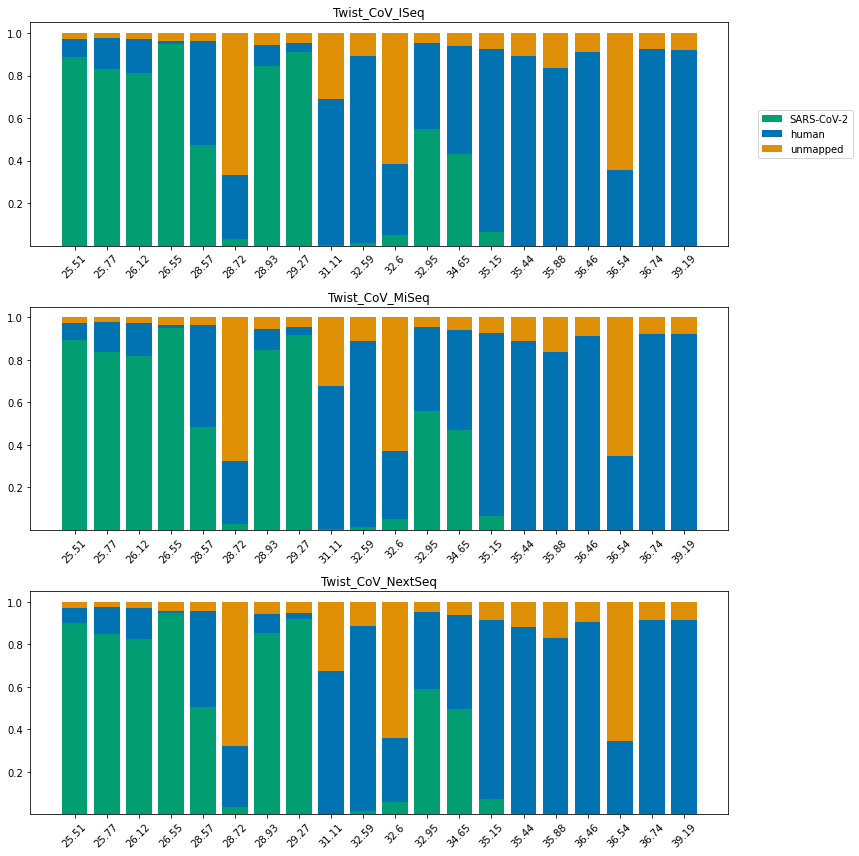

In [51]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 12
figure, ax = plt.subplots(3, 1) 

plot_barplot(aggregate_target_dfs(dfs_ontarget_tech).query("experiment == 'twist_cov_is' "),
            title="Twist_CoV_ISeq", ax=ax[0], legend=True)
plot_barplot(aggregate_target_dfs(dfs_ontarget_tech).query("experiment == 'twist_cov_ms' "),
             title="Twist_CoV_MiSeq", ax=ax[1])
plot_barplot(aggregate_target_dfs(dfs_ontarget_tech).query("experiment == 'twist_cov_ns' "),
            title="Twist_CoV_NextSeq", ax=ax[2])
plt.tight_layout()

#### MS Arbo single/double, Twist cov MS

In [15]:
ontarget_sd_dirs = [Path("../mapper_human_sarscov2/") / x 
                   for x in ["arbo_single_ms", "arbo_double_ms", "twist_cov_ms"]]

In [ ]:
dfs_ontarget_sd = get_on_target_mapping_stats(ontarget_sd_dirs,
                                             "../resources/pan_with_humans.csv")

In [33]:
# Selecting for the 19 samples in commons for both exps
sample_sel = dfs_ontarget_sd.query("experiment == 'arbo_double_ms'").sample_id
dfs_ontarget_sd = dfs_ontarget_sd.query("sample_id in @sample_sel")

/pasteur/sonic/homes/ekornobi/bioit/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


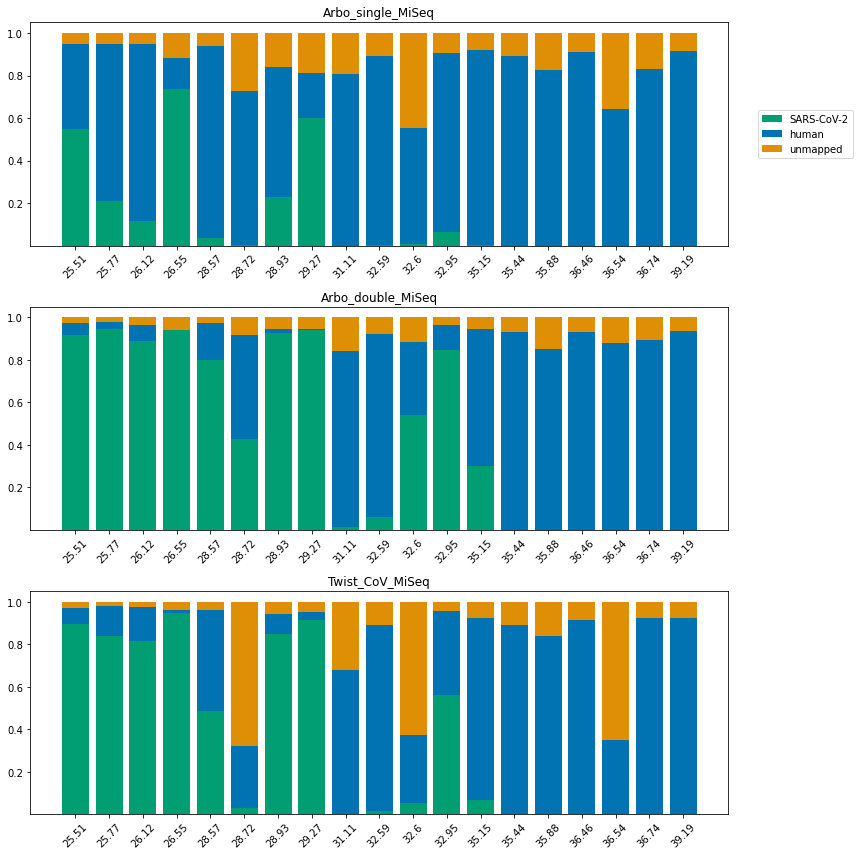

In [40]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 12
figure, ax = plt.subplots(3, 1) 

plot_barplot(aggregate_target_dfs(dfs_ontarget_sd).query("experiment == 'arbo_single_ms' "),
            title="Arbo_single_MiSeq", ax=ax[0], legend=True)
plot_barplot(aggregate_target_dfs(dfs_ontarget_sd).query("experiment == 'arbo_double_ms' "),
            title="Arbo_double_MiSeq", ax=ax[1])
plot_barplot(aggregate_target_dfs(dfs_ontarget_sd).query("experiment == 'twist_cov_ms' "),
            title="Twist_CoV_MiSeq", ax=ax[2])
plt.tight_layout()
plt.savefig("../ManuscriptMaterials/Figures/miseq_arbo_single_double_twist.pdf")

#### MS Arbo and Twist CoV

In [80]:
ontarget_mx_dirs = [Path("/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/") / x 
                    for x in ["arbo_double_ms", 
                             "twist_cov_ms","arbo_double_10plex_ms", "twist_cov_10plex_ms"]]
ontarget_mx_dirs

[PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms'),
 PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms'),
 PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms'),
 PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms')]

In [81]:
dfs_ontarget_mx = get_on_target_mapping_stats(ontarget_mx_dirs,
                                              "/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910//resources/pan_with_humans.csv")

/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4798_S16_L001/bowtie2_mapping_ref/4798_S16_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4798_S16_L001/bowtie2_mapping_ref/4798_S16_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4797_S17_L001/bowtie2_mapping_ref/4797_S17_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4797_S17_L001/bowtie2_mapping_ref/4797_S17_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4656_S18_L001/bowtie2_mapping_ref/4656_S18_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4656_S18_L001/bowtie2_mapping_ref/4656_S18_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4489_S15_L001/bowtie2_mapping_ref/4489_S15_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4489_S15_L001/bowtie2_mapping_ref/4489_S15_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4544_S19_L001/bowtie2_mapping_ref/4544_S19_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4544_S19_L001/bowtie2_mapping_ref/4544_S19_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_ms/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4660_S3_L001/bowtie2_mapping_ref/4660_S3_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4489_S16_L001/bowtie2_mapping_ref/4489_S16_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4489_S16_L001/bowtie2_mapping_ref/4489_S16_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4544_S20_L001/bowtie2_mapping_ref/4544_S20_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4544_S20_L001/bowtie2_mapping_ref/4544_S20_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4777_S13_L001/bowtie2_mapping_ref/4777_S13_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4797_S18_L001/bowtie2_mapping_ref/4797_S18_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4797_S18_L001/bowtie2_mapping_ref/4797_S18_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4716_S2_L001/bowtie2_mapping_ref/4716_S2_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4656_S19_L001/bowtie2_mapping_ref/4656_S19_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4656_S19_L001/bowtie2_mapping_ref/4656_S19_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4688_S11_L001/bowtie2_mapping_ref/4688_S11_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4676_S7_L001/bowtie2_mapping_ref/4676_S7_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4653_S8_L001/bowtie2_mapping_ref/4653_S8_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4520_S4_L001/bowtie2_mapping_ref/4520_S4_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4673_S12_L001/bowtie2_mapping_ref/4673_S12_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4510_S15_L001/bowtie2_mapping_ref/4510_S15_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4510_S15_L001/bowtie2_mapping_ref/4510_S15_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4697_S6_L001/bowtie2_mapping_ref/4697_S6_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4787_S10_L001/bowtie2_mapping_ref/4787_S10_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4885_S1_L001/bowtie2_mapping_ref/4885_S1_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4707_S5_L001/bowtie2_mapping_ref/4707_S5_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4861_S9_L001/bowtie2_mapping_ref/4861_S9_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4798_S17_L001/bowtie2_mapping_ref/4798_S17_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4798_S17_L001/bowtie2_mapping_ref/4798_S17_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_ms/4668_S14_L001/bowtie2_mapping_ref/4668_S14_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4688-M10_S7_L001/bowtie2_mapping_ref/4688-M10_S7_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4688-M10_S7_L001/bowtie2_mapping_ref/4688-M10_S7_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4777-M10_S9_L001/bowtie2_mapping_ref/4777-M10_S9_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4777-M10_S9_L001/bowtie2_mapping_ref/4777-M10_S9_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4707-M10_S1_L001/bowtie2_mapping_ref/4707-M10_S1_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4707-M10_S1_L001/bowtie2_mapping_ref/4707-M10_S1_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4697-M10_S2_L001/bowtie2_mapping_ref/4697-M10_S2_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4697-M10_S2_L001/bowtie2_mapping_ref/4697-M10_S2_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4861-M10_S5_L001/bowtie2_mapping_ref/4861-M10_S5_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4861-M10_S5_L001/bowtie2_mapping_ref/4861-M10_S5_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4673-M10_S8_L001/bowtie2_mapping_ref/4673-M10_S8_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4673-M10_S8_L001/bowtie2_mapping_ref/4673-M10_S8_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4489-M10_S10_L001/bowtie2_mapping_ref/4489-M10_S10_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4489-M10_S10_L001/bowtie2_mapping_ref/4489-M10_S10_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4787-M10_S6_L001/bowtie2_mapping_ref/4787-M10_S6_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4787-M10_S6_L001/bowtie2_mapping_ref/4787-M10_S6_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4653-M10_S4_L001/bowtie2_mapping_ref/4653-M10_S4_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4653-M10_S4_L001/bowtie2_mapping_ref/4653-M10_S4_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4676-M10_S3_L001/bowtie2_mapping_ref/4676-M10_S3_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/arbo_double_10plex_ms/4676-M10_S3_L001/bowtie2_mapping_ref/4676-M10_S3_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4688-M10_S7_L001/bowtie2_mapping_ref/4688-M10_S7_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4688-M10_S7_L001/bowtie2_mapping_ref/4688-M10_S7_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4777-M10_S9_L001/bowtie2_mapping_ref/4777-M10_S9_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4777-M10_S9_L001/bowtie2_mapping_ref/4777-M10_S9_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4707-M10_S1_L001/bowtie2_mapping_ref/4707-M10_S1_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4707-M10_S1_L001/bowtie2_mapping_ref/4707-M10_S1_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4697-M10_S2_L001/bowtie2_mapping_ref/4697-M10_S2_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4697-M10_S2_L001/bowtie2_mapping_ref/4697-M10_S2_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4861-M10_S5_L001/bowtie2_mapping_ref/4861-M10_S5_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4861-M10_S5_L001/bowtie2_mapping_ref/4861-M10_S5_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4673-M10_S8_L001/bowtie2_mapping_ref/4673-M10_S8_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4673-M10_S8_L001/bowtie2_mapping_ref/4673-M10_S8_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4489-M10_S10_L001/bowtie2_mapping_ref/4489-M10_S10_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4489-M10_S10_L001/bowtie2_mapping_ref/4489-M10_S10_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4787-M10_S6_L001/bowtie2_mapping_ref/4787-M10_S6_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4787-M10_S6_L001/bowtie2_mapping_ref/4787-M10_S6_L001.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4653-M10_S4_L001/bowtie2_mapping_ref/4653-M10_S4_L001.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_cov_10plex_ms/4653-M10_S4_L001/bowtie2_mapping_ref/4653-M10_S4_L001.sorted.bam.bai
[E::bgzf_read_block] Failed to read BGZF block data at offset 192402408 expected 8757 bytes; hread returned -1
[E::bgzf_read] Read block operation failed with error 4 after 0 of 4 bytes


KeyboardInterrupt: 

In [17]:
# Selecting for the 19 samples in commons for both exps
sample_sel = dfs_ontarget_mx.query("experiment == 'arbo_double_ms'").sample_id
df_tmp = dfs_ontarget_mx.query("sample_id in @sample_sel")

<ipython-input-11-8bf420459f4a>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.ct, rotation=45)


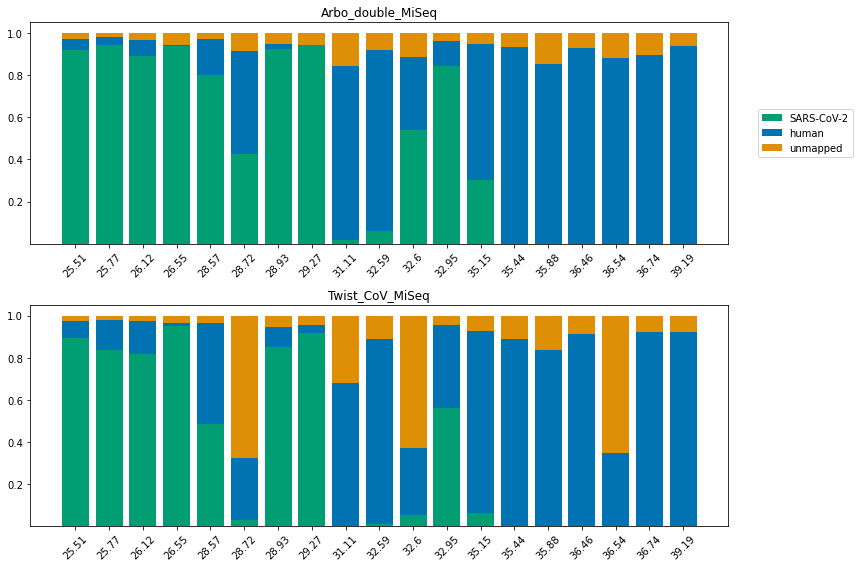

In [18]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 8
figure, ax = plt.subplots(2, 1) 

plot_barplot(aggregate_target_dfs(df_tmp).query("experiment == 'arbo_double_ms' "),
            title="Arbo double MiSeq", ax=ax[0], legend=True)
plot_barplot(aggregate_target_dfs(df_tmp).query("experiment == 'twist_cov_ms' "),
            title="Twist CoV MiSeq", ax=ax[1])
plt.tight_layout()

In [ ]:
dfs_ontarget_tech

#### Multiplexage
- Arbor double MS / Arbor double  10plex MS - Twist cov MS/ twist Cov 10plex MS

In [ ]:
# Homogeneize sample id ("-M10 added for multiplexed ones")
dfs_ontarget_mx["sample_id"] = dfs_ontarget_mx.sample_id.str.replace("-M10", "")

# Keep only samples available in all
sample_sel = dfs_ontarget_mx.query("experiment == 'arbo_double_10plex_ms'").sample_id
dfs_ontarget_mx = dfs_ontarget_mx.query("sample_id in @sample_sel")

<ipython-input-10-8bf420459f4a>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.ct, rotation=45)


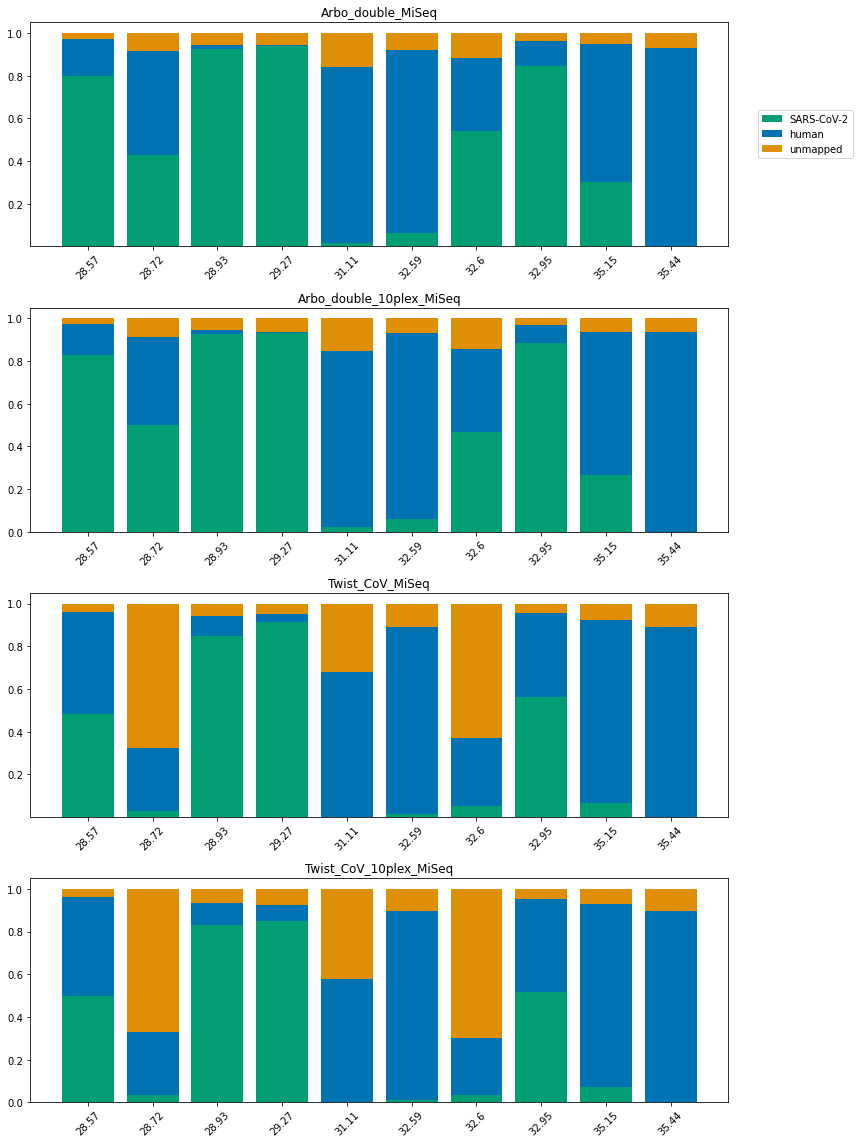

In [19]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 16
figure, ax = plt.subplots(4, 1) 

plot_barplot(aggregate_target_dfs(dfs_ontarget_mx).query("experiment == 'arbo_double_ms' "),
            title="Arbo_double_MiSeq", ax=ax[0], legend=True)
plot_barplot(aggregate_target_dfs(dfs_ontarget_mx).query("experiment == 'arbo_double_10plex_ms' "),
            title="Arbo_double_10plex_MiSeq", ax=ax[1])
plot_barplot(aggregate_target_dfs(dfs_ontarget_mx).query("experiment == 'twist_cov_ms' "),
            title="Twist_CoV_MiSeq", ax=ax[2])
plot_barplot(aggregate_target_dfs(dfs_ontarget_mx).query("experiment == 'twist_cov_10plex_ms' "),
            title="Twist_CoV_10plex_MiSeq", ax=ax[3])
plt.tight_layout()

#### Panviral
- Twist Panviral NS et Illumina Resv V2 NS

In [63]:
ontarget_ti_dirs = [Path("/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/") / x 
                    for x in ["twist_panviral_ns", "illumina_resv_v2_ns"]]
ontarget_ti_dirs

[PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns'),
 PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns')]

In [64]:
dfs_ontarget_ti = get_on_target_mapping_stats(ontarget_ti_dirs,
                                              "/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/resources/pan_with_humans.csv")


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4489_S15/bowtie2_mapping_ref/4489_S15.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4489_S15/bowtie2_mapping_ref/4489_S15.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4656_S18/bowtie2_mapping_ref/4656_S18.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4656_S18/bowtie2_mapping_ref/4656_S18.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4797_S17/bowtie2_mapping_ref/4797_S17.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4797_S17/bowtie2_mapping_ref/4797_S17.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4520_S4/bowtie2_mapping_ref/4520_S4.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4520_S4/bowtie2_mapping_ref/4520_S4.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4787_S10/bowtie2_mapping_ref/4787_S10.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4787_S10/bowtie2_mapping_ref/4787_S10.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4777_S13/bowtie2_mapping_ref/4777_S13.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4777_S13/bowtie2_mapping_ref/4777_S13.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4697_S6/bowtie2_mapping_ref/4697_S6.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4697_S6/bowtie2_mapping_ref/4697_S6.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4707_S5/bowtie2_mapping_ref/4707_S5.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4707_S5/bowtie2_mapping_ref/4707_S5.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4688_S11/bowtie2_mapping_ref/4688_S11.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4688_S11/bowtie2_mapping_ref/4688_S11.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4861_S9/bowtie2_mapping_ref/4861_S9.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4861_S9/bowtie2_mapping_ref/4861_S9.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4673_S12/bowtie2_mapping_ref/4673_S12.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4673_S12/bowtie2_mapping_ref/4673_S12.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4885_S1/bowtie2_mapping_ref/4885_S1.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4885_S1/bowtie2_mapping_ref/4885_S1.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4660_S3/bowtie2_mapping_ref/4660_S3.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4660_S3/bowtie2_mapping_ref/4660_S3.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4544_S19/bowtie2_mapping_ref/4544_S19.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4544_S19/bowtie2_mapping_ref/4544_S19.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4798_S16/bowtie2_mapping_ref/4798_S16.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4798_S16/bowtie2_mapping_ref/4798_S16.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4668_S14/bowtie2_mapping_ref/4668_S14.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4668_S14/bowtie2_mapping_ref/4668_S14.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4716_S2/bowtie2_mapping_ref/4716_S2.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4716_S2/bowtie2_mapping_ref/4716_S2.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4676_S7/bowtie2_mapping_ref/4676_S7.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4676_S7/bowtie2_mapping_ref/4676_S7.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4653_S8/bowtie2_mapping_ref/4653_S8.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/twist_panviral_ns/4653_S8/bowtie2_mapping_ref/4653_S8.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4707_Resv2_S5/bowtie2_mapping_ref/4707_Resv2_S5.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4707_Resv2_S5/bowtie2_mapping_ref/4707_Resv2_S5.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4797_Resv2_S17/bowtie2_mapping_ref/4797_Resv2_S17.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4797_Resv2_S17/bowtie2_mapping_ref/4797_Resv2_S17.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4697_Resv2_S6/bowtie2_mapping_ref/4697_Resv2_S6.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4697_Resv2_S6/bowtie2_mapping_ref/4697_Resv2_S6.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4861_Resv2_S9/bowtie2_mapping_ref/4861_Resv2_S9.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4861_Resv2_S9/bowtie2_mapping_ref/4861_Resv2_S9.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4787_Resv2_S10/bowtie2_mapping_ref/4787_Resv2_S10.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4787_Resv2_S10/bowtie2_mapping_ref/4787_Resv2_S10.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4798_Resv2_S16/bowtie2_mapping_ref/4798_Resv2_S16.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4798_Resv2_S16/bowtie2_mapping_ref/4798_Resv2_S16.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4660_Resv2_S3/bowtie2_mapping_ref/4660_Resv2_S3.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4660_Resv2_S3/bowtie2_mapping_ref/4660_Resv2_S3.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4673_Resv2_S12/bowtie2_mapping_ref/4673_Resv2_S12.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4673_Resv2_S12/bowtie2_mapping_ref/4673_Resv2_S12.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4520_Resv2_S4/bowtie2_mapping_ref/4520_Resv2_S4.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4520_Resv2_S4/bowtie2_mapping_ref/4520_Resv2_S4.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4653_Resv2_S8/bowtie2_mapping_ref/4653_Resv2_S8.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4653_Resv2_S8/bowtie2_mapping_ref/4653_Resv2_S8.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4489_Resv2_S15/bowtie2_mapping_ref/4489_Resv2_S15.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4489_Resv2_S15/bowtie2_mapping_ref/4489_Resv2_S15.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4544_Resv2_S19/bowtie2_mapping_ref/4544_Resv2_S19.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4544_Resv2_S19/bowtie2_mapping_ref/4544_Resv2_S19.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4676_Resv2_S7/bowtie2_mapping_ref/4676_Resv2_S7.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4676_Resv2_S7/bowtie2_mapping_ref/4676_Resv2_S7.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4668_Resv2_S14/bowtie2_mapping_ref/4668_Resv2_S14.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4668_Resv2_S14/bowtie2_mapping_ref/4668_Resv2_S14.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4716_Resv2_S2/bowtie2_mapping_ref/4716_Resv2_S2.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4716_Resv2_S2/bowtie2_mapping_ref/4716_Resv2_S2.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4656_Resv2_S18/bowtie2_mapping_ref/4656_Resv2_S18.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4656_Resv2_S18/bowtie2_mapping_ref/4656_Resv2_S18.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4777_Resv2_S13/bowtie2_mapping_ref/4777_Resv2_S13.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4777_Resv2_S13/bowtie2_mapping_ref/4777_Resv2_S13.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4885_Resv2_S1/bowtie2_mapping_ref/4885_Resv2_S1.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4885_Resv2_S1/bowtie2_mapping_ref/4885_Resv2_S1.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4688_Resv2_S11/bowtie2_mapping_ref/4688_Resv2_S11.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4688_Resv2_S11/bowtie2_mapping_ref/4688_Resv2_S11.sorted.bam.bai


/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


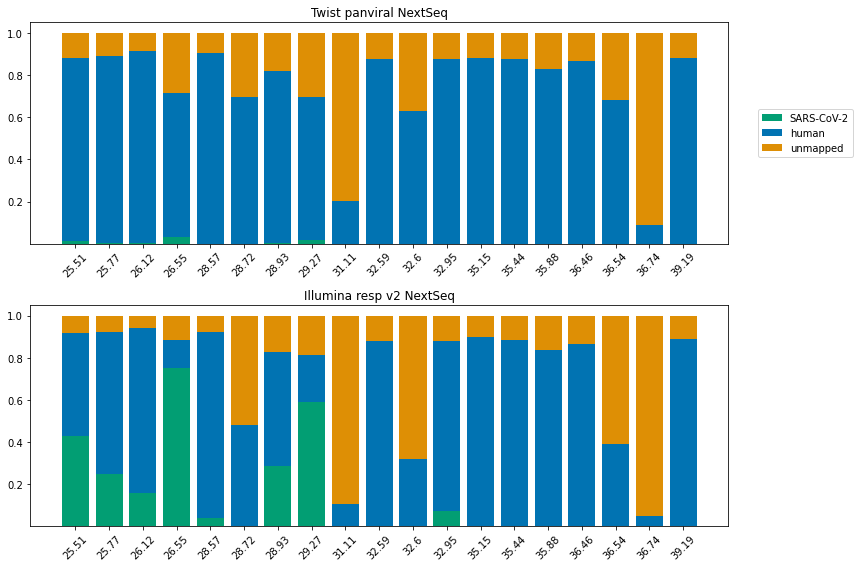

In [75]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 8
figure, ax = plt.subplots(2, 1)

plot_barplot(aggregate_target_dfs(dfs_ontarget_ti).query("experiment == 'twist_panviral_ns' "),
            title="Twist panviral NextSeq", ax=ax[0], legend=True)
plot_barplot(aggregate_target_dfs(dfs_ontarget_ti).query("experiment == 'illumina_resv_v2_ns' "),
            title="Illumina resp v2 NextSeq", ax=ax[1])
plt.tight_layout()
from pylab import savefig
savefig("ontarget_twist_panviral_vsillumina.png", dpi=200)
dfs_ontarget_ti.to_csv("ontarget_twist_panviral_vsillumina.csv")

#### illumina resvp v1 vs v2
- Illumina respiratory panel v1 vs v2

In [70]:
ontarget_ii_dirs = [Path("/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/") / x 
                    for x in ["illumina_resv_ns", "illumina_resv_v2_ns"]]
ontarget_ii_dirs

[PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns'),
 PosixPath('/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns')]

In [71]:
dfs_ontarget_ii = get_on_target_mapping_stats(ontarget_ii_dirs,
                                              "/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/resources/pan_with_humans.csv")
dfs_ontarget_ii

/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4489_S15/bowtie2_mapping_ref/4489_S15.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4489_S15/bowtie2_mapping_ref/4489_S15.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4656_S18/bowtie2_mapping_ref/4656_S18.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4656_S18/bowtie2_mapping_ref/4656_S18.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4797_S17/bowtie2_mapping_ref/4797_S17.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4797_S17/bowtie2_mapping_ref/4797_S17.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4520_S4/bowtie2_mapping_ref/4520_S4.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4520_S4/bowtie2_mapping_ref/4520_S4.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4787_S10/bowtie2_mapping_ref/4787_S10.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4787_S10/bowtie2_mapping_ref/4787_S10.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4777_S13/bowtie2_mapping_ref/4777_S13.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4777_S13/bowtie2_mapping_ref/4777_S13.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4697_S6/bowtie2_mapping_ref/4697_S6.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4697_S6/bowtie2_mapping_ref/4697_S6.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4707_S5/bowtie2_mapping_ref/4707_S5.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4707_S5/bowtie2_mapping_ref/4707_S5.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4688_S11/bowtie2_mapping_ref/4688_S11.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4688_S11/bowtie2_mapping_ref/4688_S11.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4861_S9/bowtie2_mapping_ref/4861_S9.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4861_S9/bowtie2_mapping_ref/4861_S9.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4673_S12/bowtie2_mapping_ref/4673_S12.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4673_S12/bowtie2_mapping_ref/4673_S12.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4885_S1/bowtie2_mapping_ref/4885_S1.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4885_S1/bowtie2_mapping_ref/4885_S1.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4660_S3/bowtie2_mapping_ref/4660_S3.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4660_S3/bowtie2_mapping_ref/4660_S3.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4544_S19/bowtie2_mapping_ref/4544_S19.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4544_S19/bowtie2_mapping_ref/4544_S19.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4798_S16/bowtie2_mapping_ref/4798_S16.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4798_S16/bowtie2_mapping_ref/4798_S16.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4668_S14/bowtie2_mapping_ref/4668_S14.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4668_S14/bowtie2_mapping_ref/4668_S14.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4716_S2/bowtie2_mapping_ref/4716_S2.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4716_S2/bowtie2_mapping_ref/4716_S2.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4676_S7/bowtie2_mapping_ref/4676_S7.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4676_S7/bowtie2_mapping_ref/4676_S7.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4653_S8/bowtie2_mapping_ref/4653_S8.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_ns/4653_S8/bowtie2_mapping_ref/4653_S8.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4707_Resv2_S5/bowtie2_mapping_ref/4707_Resv2_S5.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4707_Resv2_S5/bowtie2_mapping_ref/4707_Resv2_S5.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4797_Resv2_S17/bowtie2_mapping_ref/4797_Resv2_S17.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4797_Resv2_S17/bowtie2_mapping_ref/4797_Resv2_S17.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4697_Resv2_S6/bowtie2_mapping_ref/4697_Resv2_S6.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4697_Resv2_S6/bowtie2_mapping_ref/4697_Resv2_S6.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4861_Resv2_S9/bowtie2_mapping_ref/4861_Resv2_S9.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4861_Resv2_S9/bowtie2_mapping_ref/4861_Resv2_S9.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4787_Resv2_S10/bowtie2_mapping_ref/4787_Resv2_S10.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4787_Resv2_S10/bowtie2_mapping_ref/4787_Resv2_S10.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4798_Resv2_S16/bowtie2_mapping_ref/4798_Resv2_S16.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4798_Resv2_S16/bowtie2_mapping_ref/4798_Resv2_S16.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4660_Resv2_S3/bowtie2_mapping_ref/4660_Resv2_S3.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4660_Resv2_S3/bowtie2_mapping_ref/4660_Resv2_S3.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4673_Resv2_S12/bowtie2_mapping_ref/4673_Resv2_S12.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4673_Resv2_S12/bowtie2_mapping_ref/4673_Resv2_S12.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4520_Resv2_S4/bowtie2_mapping_ref/4520_Resv2_S4.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4520_Resv2_S4/bowtie2_mapping_ref/4520_Resv2_S4.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4653_Resv2_S8/bowtie2_mapping_ref/4653_Resv2_S8.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4653_Resv2_S8/bowtie2_mapping_ref/4653_Resv2_S8.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4489_Resv2_S15/bowtie2_mapping_ref/4489_Resv2_S15.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4489_Resv2_S15/bowtie2_mapping_ref/4489_Resv2_S15.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4544_Resv2_S19/bowtie2_mapping_ref/4544_Resv2_S19.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4544_Resv2_S19/bowtie2_mapping_ref/4544_Resv2_S19.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4676_Resv2_S7/bowtie2_mapping_ref/4676_Resv2_S7.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4676_Resv2_S7/bowtie2_mapping_ref/4676_Resv2_S7.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4668_Resv2_S14/bowtie2_mapping_ref/4668_Resv2_S14.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4668_Resv2_S14/bowtie2_mapping_ref/4668_Resv2_S14.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4716_Resv2_S2/bowtie2_mapping_ref/4716_Resv2_S2.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4716_Resv2_S2/bowtie2_mapping_ref/4716_Resv2_S2.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4656_Resv2_S18/bowtie2_mapping_ref/4656_Resv2_S18.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4656_Resv2_S18/bowtie2_mapping_ref/4656_Resv2_S18.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4777_Resv2_S13/bowtie2_mapping_ref/4777_Resv2_S13.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4777_Resv2_S13/bowtie2_mapping_ref/4777_Resv2_S13.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4885_Resv2_S1/bowtie2_mapping_ref/4885_Resv2_S1.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4885_Resv2_S1/bowtie2_mapping_ref/4885_Resv2_S1.sorted.bam.bai


/pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4688_Resv2_S11/bowtie2_mapping_ref/4688_Resv2_S11.sorted.bam


[W::hts_idx_load3] The index file is older than the data file: /pasteur/zeus/projets/p02/Biomics/Bioinfo/InProgress/B3910/mapper_human_sarscov2/illumina_resv_v2_ns/4688_Resv2_S11/bowtie2_mapping_ref/4688_Resv2_S11.sorted.bam.bai


,human,SARS-CoV-2,other,total,experiment,sample_id
0,63686696,62831,4553233,68302760,illumina_resv_ns,4489
1,7304709,0,2567017,9871726,illumina_resv_ns,4656
2,18166048,0,1400062,19566110,illumina_resv_ns,4797
3,50473643,20507901,5309860,76291404,illumina_resv_ns,4520
4,34590487,6518,2814971,37411976,illumina_resv_ns,4787
5,60988245,0,6590983,67579228,illumina_resv_ns,4777
6,27013032,49781,7286663,34349476,illumina_resv_ns,4697
7,69808088,832883,3918963,74559934,illumina_resv_ns,4707
8,32047305,2021,88882624,120931950,illumina_resv_ns,4688
9,26832338,784801,3457173,31074312,illumina_resv_ns,4861


/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/cokelaer/miniconda3/envs/sequana/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


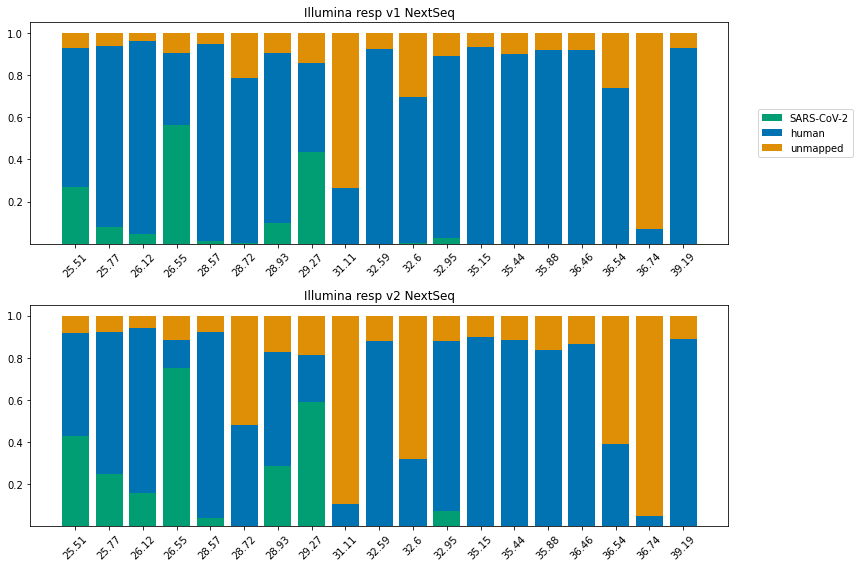

In [74]:
matplotlib.pyplot.rcParams['figure.figsize'] = 12, 8
figure, ax = plt.subplots(2, 1)

plot_barplot(aggregate_target_dfs(dfs_ontarget_ii).query("experiment == 'illumina_resv_ns' "),
            title="Illumina resp v1 NextSeq", ax=ax[0], legend=True)
plot_barplot(aggregate_target_dfs(dfs_ontarget_ii).query("experiment == 'illumina_resv_v2_ns' "),
            title="Illumina resp v2 NextSeq", ax=ax[1])
plt.tight_layout()

from pylab import savefig
savefig("ontarget_illumina_v1_v2.png", dpi=200)
dfs_ontarget_ii.to_csv("ontarget_illumina_v1_v2.csv")

In [82]:
design_df

,experiment,path,description
0,arbo_double_is,2020/ISeq100/20200423_FS10001183_4_BPL20309-2627,Arbor Sars-cov simple capture
1,arbo_double_ms,2020/MiSeq/200427_M01626_0470_000000000-CVJBF,Arbor Sars-cov double capture : Miseq
2,arbo_double_10plex_ms,2020/MiSeq/200511_M05218_0203_000000000-J533H,Arbor Double Capture Sars-cov 10plex
3,arbo_single_is,2020/ISeq100/20200428_FS10001183_5_BPL20316-3113,Arbor Sars-cov SIMPLE CAPTURE : Iseq100
4,arbo_single_ms,2020/MiSeq/200504_M05218_0201_000000000-J534C,Arbor Sars-cov SIMPLE CAPTURE : Miseq
5,illumina_resv_is,2020/ISeq100/20200421_FS10001183_3_BPL20309-1531,Illumina capture ResV : ISeq100
6,illumina_resv_ms,2020/MiSeq/200504_M01626_0471_000000000-J4VCN,Illumina capture ResV : Miseq
7,illumina_resv_ns,2020/NextSeq500/200504_NB501291_0237_AHM3NCBGXF,Illumina capture ResV : Nextseq
8,meta_is,2020/ISeq100/20200416_FS10001183_1_BPL20316-3215,Pré-capture ( métagénomique shotgun) : Iseq100
9,meta_ns,2020/NextSeq500/200417_NS500199_0381_AH3YVWBGXB,Pré-capture ( métagénomique shotgun) : NextSeq500
